In [2]:
!nvidia-smi

Mon Jun 20 19:12:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P3    27W /  N/A |    645MiB /  7973MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Downloading Avila Dataset

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00459/avila.zip
!unzip -q avila.zip
!cat avila/avila-tr.txt avila/avila-ts.txt > avila/avila.txt

--2022-06-20 18:37:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00459/avila.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584600 (571K) [application/x-httpd-php]
Saving to: 'avila.zip'

avila.zip           100%[===================>] 570.90K   720KB/s    in 0.8s    

2022-06-20 18:37:17 (720 KB/s) - 'avila.zip' saved [584600/584600]



In [40]:
!pip install scikit-learn-intelex

  Using cached scikit_learn_intelex-2021.6.3-py38-none-manylinux1_x86_64.whl (87 kB)
  Using cached daal4py-2021.6.3-py38-none-manylinux1_x86_64.whl (26.1 MB)
  Using cached daal-2021.6.0-py2.py3-none-manylinux1_x86_64.whl (300.3 MB)
  Using cached tbb-2021.6.0-py2.py3-none-manylinux1_x86_64.whl (4.0 MB)


In [4]:
import numpy as np
import pandas as pd
from sklearnex import patch_sklearn
patch_sklearn()
import sklearn as sk
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats
import scikit_posthocs as sp

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
random_state = 13

##Loading Data

In [6]:
df = pd.read_csv('avila/avila.txt', header=None)
#df = pd.get_dummies(df)
df.columns = df.columns.astype(str) # to avoid warning with MinMaxScaler
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


In [7]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.086700e+04,20867.000000,20867.000000,20867.000000,2.086700e+04,20867.000000,20867.000000,20867.000000,20867.000000,20867.000000
mean,-3.306656e-09,0.018498,0.002329,0.000115,5.697992e-08,0.002540,0.003977,0.000028,0.002108,0.000069
std,1.000007e+00,2.853117,1.058203,0.999997,9.999948e-01,1.065179,1.153325,1.000003,1.045362,1.000010
min,-3.498799e+00,-2.426761,-3.210528,-5.440122,-4.922215e+00,-7.450257,-11.935457,-4.247781,-5.486218,-6.719324
25%,-1.289290e-01,-0.259834,0.064919,-0.527256,1.723400e-01,-0.598658,-0.044076,-0.543914,-0.372457,-0.515235
50%,5.622900e-02,-0.055704,0.217845,0.089437,2.617180e-01,-0.058835,0.220177,0.108279,0.064084,-0.025918
75%,2.043550e-01,0.203385,0.352988,0.643738,2.617180e-01,0.564038,0.446679,0.648814,0.500624,0.528425
max,1.181992e+01,386.000000,50.000000,3.987152,1.066121e+00,53.000000,83.000000,13.173081,44.000000,11.911338


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20867 entries, 0 to 20866
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20867 non-null  float64
 1   1       20867 non-null  float64
 2   2       20867 non-null  float64
 3   3       20867 non-null  float64
 4   4       20867 non-null  float64
 5   5       20867 non-null  float64
 6   6       20867 non-null  float64
 7   7       20867 non-null  float64
 8   8       20867 non-null  float64
 9   9       20867 non-null  float64
 10  10      20867 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.8+ MB


In [9]:
df.shape

(20867, 11)

In [10]:
df['10'].value_counts()

A    8572
F    3923
E    2190
I    1663
X    1044
H    1039
G     893
D     705
Y     533
C     206
W      89
B      10
Name: 10, dtype: int64

In [11]:
df['10'].value_counts() / len(df)

A    0.410792
F    0.188000
E    0.104950
I    0.079695
X    0.050031
H    0.049792
G    0.042795
D    0.033785
Y    0.025543
C    0.009872
W    0.004265
B    0.000479
Name: 10, dtype: float64

<AxesSubplot:>

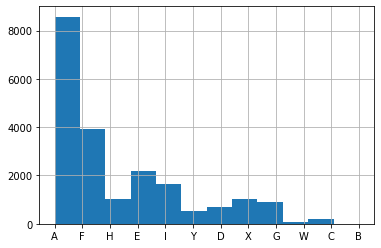

In [12]:
df['10'].hist(bins=12)

In [13]:
X = df.drop('10', axis=1, inplace=False)
Y = df['10']

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler(with_std=True, with_mean=True)
scaler.fit(X.to_numpy())

StandardScaler()

In [16]:
X = scaler.transform(X)
X = pd.DataFrame(X)

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [17]:
X.head()

,0,1,2,3,4,5,6,7,8,9
0,0.266078,-0.064534,0.301132,0.483196,0.172345,0.254259,0.318392,0.929814,0.238263,0.159278
1,0.130294,0.298711,-3.036217,0.062379,0.261726,1.345835,1.267637,0.636188,0.268091,0.515525
2,-0.116587,0.018022,0.062510,-0.783283,0.261726,0.410198,-0.074399,-0.888283,-0.119687,0.582878
3,0.031542,0.097826,-3.036217,-0.583721,-0.721463,-0.291530,0.612986,1.051687,0.566383,-0.534071
4,0.229047,0.276696,-0.051760,0.082521,0.261726,0.137304,0.547520,0.051035,0.029458,-0.086723


In [18]:
X.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.086700e+04,2.086700e+04,2.086700e+04,2.086700e+04,2.086700e+04,2.086700e+04,2.086700e+04,2.086700e+04,2.086700e+04,2.086700e+04
mean,-1.004505e-17,-3.022028e-18,6.129184e-18,1.021531e-18,-3.966944e-17,1.753628e-17,-7.831736e-18,-1.362041e-18,-1.498245e-17,-2.383572e-18
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-3.498857e+00,-8.570689e-01,-3.036217e+00,-5.440381e+00,-4.922359e+00,-6.996925e+00,-1.035243e+01,-4.247898e+00,-5.250292e+00,-6.719488e+00
25%,-1.289312e-01,-9.755603e-02,5.914898e-02,-5.273854e-01,1.723450e-01,-5.644237e-01,-4.166590e-02,-5.439535e-01,-3.583198e-01,-5.153121e-01
50%,5.622994e-02,-2.600800e-02,2.036672e-01,8.932394e-02,2.617256e-01,-5.762055e-02,1.874624e-01,1.082531e-01,5.928802e-02,-2.598775e-02
75%,2.043584e-01,6.480329e-02,3.313802e-01,6.436396e-01,2.617256e-01,5.271526e-01,3.838575e-01,6.487989e-01,4.768948e-01,5.283631e-01
max,1.182011e+01,1.352874e+02,4.724884e+01,3.987142e+00,1.066152e+00,4.975572e+01,7.196412e+01,1.317333e+01,4.208966e+01,1.191144e+01


In [19]:
class ParzenWindowClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, h=1, kernel='gaussian'):
      self.h = h
      self.kernel = kernel

    def set_params(self, **parameters):
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self

    def get_params(self, deep=True):
      return {"h": self.h, "kernel": self.kernel}

    def fit(self, X, y=None):
      self.classes_ = np.unique(y)
      self.n_classes = len(self.classes_)
      self.X_ = np.array(X)
      self.y_ = y
      if not isinstance(y, np.ndarray):
        self.y_ = np.array(y.values.ravel())
      self.n_features_in_ = X.shape[1]
      self.prior_ = None

      if self.y_.shape[0] != self.X_.shape[0]:
        raise ValueError(f"Size of y {self.y_.shape[0]} does not match X size {self.X_.shape[0]}.")

      tmp = GaussianNB()
      tmp.fit(X, y)
      self.prior_ = tmp.class_prior_

      return self

    def predict_proba(self, X, y=None):
      P = np.zeros(len(X)*len(self.classes_)).reshape(len(X), len(self.classes_))

      for i in range(0, self.n_classes):
        class_examples_from_training_data = self.X_[self.y_ == self.classes_[i]]
        target_class = self.classes_[i]

        if class_examples_from_training_data.size == 0:
          continue
        else:
          kde = KernelDensity(kernel=self.kernel, bandwidth=self.h)
          kde = kde.fit(class_examples_from_training_data)
          
          P[:,i] = np.exp(kde.score_samples(X)) * self.prior_[i]     

      return P

    def predict_log_proba(self, X, y=None):
      return np.log(self.predict_proba(X, y))

    def predict(self, X, y=None):
      probabilities = self.predict_proba(np.array(X), np.array(y))
      return self.classes_[np.argmax(probabilities, axis=1)]

In [20]:
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=random_state)

In [92]:
scoring = {'Accuracy': 'accuracy',
           'Precision': make_scorer(precision_score, zero_division=0, average='macro'),
           'F1': make_scorer(f1_score, zero_division=0, average='macro'),
           'Recall': make_scorer(recall_score, zero_division=0, average='macro')}

#Bayes with Parzen Window - Non Normalized Data

In [143]:
%%time
params = {'h': [0.01, 0.1, 1, 10]}
pw_clf = GridSearchCV(ParzenWindowClassifier(),
                      param_grid=params,
                      scoring=scoring,
                      n_jobs=-1,
                      cv=rkf,
                      refit='Accuracy')
pw_clf.fit(X, Y)

CPU times: user 7.71 s, sys: 480 ms, total: 8.19 s
Wall time: 4min 22s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=30, n_splits=10, random_state=13),
             estimator=ParzenWindowClassifier(), n_jobs=-1,
             param_grid={'h': [0.01, 0.1, 1, 10]}, refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'F1': make_scorer(f1_score, zero_division=0, average=macro),
                      'Precision': make_scorer(precision_score, zero_division=0, average=macro),
                      'Recall': make_scorer(recall_score, zero_division=0, average=macro)})

In [94]:
pw_clf.cv_results_

{'mean_fit_time': array([0.05916586, 0.05957385, 0.06222054]),
 'std_fit_time': array([0.01175915, 0.00899832, 0.01116693]),
 'mean_score_time': array([1.8110953 , 3.76108608, 5.1722834 ]),
 'std_score_time': array([0.09580001, 0.17374048, 0.33663914]),
 'param_h': masked_array(data=[0.01, 0.1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'h': 0.01}, {'h': 0.1}, {'h': 1}],
 'split0_test_Accuracy': array([0.39434595, 0.76042166, 0.5088644 ]),
 'split1_test_Accuracy': array([0.38811691, 0.76137997, 0.49880211]),
 'split2_test_Accuracy': array([0.39482511, 0.7709631 , 0.50503115]),
 'split3_test_Accuracy': array([0.34978438, 0.76281744, 0.51126018]),
 'split4_test_Accuracy': array([0.37422137, 0.74940105, 0.50694777]),
 'split5_test_Accuracy': array([0.41542885, 0.76425491, 0.51030187]),
 'split6_test_Accuracy': array([0.37757547, 0.75754672, 0.51269765]),
 'split7_test_Accuracy': array([0.39165868, 0.76893576, 0.50047939])

In [95]:
pw_metrics_results = {}
best_param_idx = pw_clf.cv_results_['params'].index(pw_clf.best_params_)
for metric in scoring:
  pw_metrics_results[metric] = [v[best_param_idx] for k, v in pw_clf.cv_results_.items()
                                if 'split' in k and metric in k]

In [96]:
pw_metrics_results

{'Accuracy': [0.7604216578821275,
  0.761379971250599,
  0.7709631049353138,
  0.7628174413033062,
  0.7494010541447054,
  0.7642549113560134,
  0.757546717776713,
  0.7689357622243528,
  0.7569511025886865,
  0.7766059443911792,
  0.7652132247244849,
  0.747963584091998,
  0.7724005749880211,
  0.7513176808816483,
  0.7465261140392908,
  0.7652132247244849,
  0.7704839482510781,
  0.7627037392138063,
  0.7583892617449665,
  0.7646212847555129,
  0.7527551509343555,
  0.7714422616195495,
  0.7498802108289411,
  0.7628174413033062,
  0.7656923814087206,
  0.7752755150934355,
  0.7623382846190704,
  0.7569511025886865,
  0.7559923298178332,
  0.7718120805369127,
  0.7656923814087206,
  0.7661715380929564,
  0.7594633445136559,
  0.7666506947771922,
  0.7450886439865836,
  0.7700047915668423,
  0.7757546717776713,
  0.7698945349952061,
  0.7694151486097794,
  0.7540747842761265,
  0.75563009103977,
  0.7589841878294202,
  0.7747963584091998,
  0.7661715380929564,
  0.7637757546717777,
  0

In [144]:
pw_clf.best_score_

0.7618616554136053

In [145]:
pw_clf.best_params_

{'h': 0.1}

In [98]:
pw_clf.cv_results_['params'].index(pw_clf.best_params_)

1

In [99]:
from sklearn.metrics import accuracy_score

#KNN

In [100]:
%%time
params = {'metric': ['euclidean', 'manhattan', 'chebyshev'],
          'n_neighbors': range(1, 101, 10)}
knn_clf = GridSearchCV(KNeighborsClassifier(),
                       param_grid=params,
                       scoring=scoring,
                       n_jobs=-1,
                       cv=rkf,
                       refit='Accuracy')
knn_clf.fit(X, Y.ravel())

CPU times: user 24.7 s, sys: 1.52 s, total: 26.2 s
Wall time: 9min 6s


/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2600 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2600 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/sklearnex/neighbors/knn_classification.py", line 220, in fit
    dispatch(self, 'neighbors.KNeighborsClassifier.fit', {
  File "/home/lucas

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=30, n_splits=10, random_state=13),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': range(1, 101, 10)},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'F1': make_scorer(f1_score, zero_division=0, average=macro),
                      'Precision': make_scorer(precision_score, zero_division=0, average=macro),
                      'Recall': make_scorer(recall_score, zero_division=0, average=macro)})

In [101]:
knn_clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 1}

In [102]:
knn_clf.best_score_

0.8476078282472129

In [103]:
knn_metrics_results = {}
best_param_idx = knn_clf.cv_results_['params'].index(knn_clf.best_params_)
for metric in scoring:
  knn_metrics_results[metric] = [v[best_param_idx] for k, v in knn_clf.cv_results_.items()
                                if 'split' in k and metric in k]

#Naive Bayes

In [104]:
%%time
# Setting the default values, just because the param_grid cannot be None
params = {'var_smoothing': [1e-10, 1e-09, 1e-08]}
nb_clf = GridSearchCV(GaussianNB(),
                      param_grid=params,
                      scoring=scoring,
                      n_jobs=-1,
                      cv=rkf,
                      refit='Accuracy')

nb_clf.fit(X, Y.ravel())

CPU times: user 1.67 s, sys: 125 ms, total: 1.79 s
Wall time: 4.99 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=30, n_splits=10, random_state=13),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-10, 1e-09, 1e-08]},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'F1': make_scorer(f1_score, zero_division=0, average=macro),
                      'Precision': make_scorer(precision_score, zero_division=0, average=macro),
                      'Recall': make_scorer(recall_score, zero_division=0, average=macro)})

In [105]:
nb_clf.best_params_

{'var_smoothing': 1e-10}

In [106]:
nb_clf.best_score_

0.30105771426182537

In [107]:
nb_metrics_results = {}
best_param_idx = nb_clf.cv_results_['params'].index(nb_clf.best_params_)
for metric in scoring:
  nb_metrics_results[metric] = [v[best_param_idx] for k, v in nb_clf.cv_results_.items()
                                if 'split' in k and metric in k]

#Logistic Regression

In [108]:
%%time
params = {'class_weight': ['balanced', None],
          'C': [0.1, 1],
          'multi_class': ['ovr'],
          'max_iter': [1000]}
lr_clf = GridSearchCV(LogisticRegression(random_state=random_state),
                      param_grid=params,
                      scoring=scoring,
                      n_jobs=-1,
                      cv=rkf,
                      refit='Accuracy')

lr_clf.fit(X, Y.ravel())

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

CPU times: user 4.67 s, sys: 344 ms, total: 5.01 s
Wall time: 2min 7s


/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=30, n_splits=10, random_state=13),
             estimator=LogisticRegression(random_state=13), n_jobs=-1,
             param_grid={'C': [0.1, 1], 'class_weight': ['balanced', None],
                         'max_iter': [1000], 'multi_class': ['ovr']},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'F1': make_scorer(f1_score, zero_division=0, average=macro),
                      'Precision': make_scorer(precision_score, zero_division=0, average=macro),
                      'Recall': make_scorer(recall_score, zero_division=0, average=macro)})

In [109]:
lr_clf.best_params_

{'C': 1, 'class_weight': None, 'max_iter': 1000, 'multi_class': 'ovr'}

In [110]:
lr_clf.best_score_

0.533624073787373

In [111]:
lr_metrics_results = {}
best_param_idx = lr_clf.cv_results_['params'].index(lr_clf.best_params_)
for metric in scoring:
  lr_metrics_results[metric] = [v[best_param_idx] for k, v in lr_clf.cv_results_.items()
                                if 'split' in k and metric in k]

#Voto Majoritário

In [112]:
%%time
params = {'voting': ['hard', 'soft']}
vc_clf = GridSearchCV(VotingClassifier(estimators=[('nb', GaussianNB(var_smoothing=1e-10)),
                                                   ('lr', LogisticRegression(random_state=random_state,
                                                                             multi_class='ovr',
                                                                             class_weight=None,
                                                                             C=1)),
                                                   ('knn', KNeighborsClassifier(metric='manhattan',
                                                                                n_neighbors=1)),
                                                   ('pw', ParzenWindowClassifier(h=0.1))]),
                      param_grid=params,
                      scoring=scoring,
                      n_jobs=-1,
                      cv=rkf,
                      refit='Accuracy')

vc_clf.fit(X, Y.ravel())

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

CPU times: user 5.15 s, sys: 203 ms, total: 5.36 s
Wall time: 3min 22s


/home/lucas-a-alcantara/miniconda3/envs/rapids-22.04/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=30, n_splits=10, random_state=13),
             estimator=VotingClassifier(estimators=[('nb',
                                                     GaussianNB(var_smoothing=1e-10)),
                                                    ('lr',
                                                     LogisticRegression(C=1,
                                                                        multi_class='ovr',
                                                                        random_state=13)),
                                                    ('knn',
                                                     KNeighborsClassifier(metric='manhattan',
                                                                          n_neighbors=1)),
                                                    ('pw',
                                                     ParzenWindowClassifier(h=0.1))]),
             n_jobs=-1, param_grid={'voting': ['hard', 'soft']},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'F1': make_scorer(f1_score, zero_division=0, average=macro),
                      'Precision': make_scorer(precision_score, zero_division=0, average=macro),
                      'Recall': make_scorer(recall_score, zero_division=0, average=macro)})

In [113]:
vc_clf.best_params_

{'voting': 'soft'}

In [114]:
vc_clf.best_score_

0.828892460487184

In [115]:
vc_metrics_results = {}
best_param_idx = vc_clf.cv_results_['params'].index(vc_clf.best_params_)
for metric in scoring:
  vc_metrics_results[metric] = [v[best_param_idx] for k, v in vc_clf.cv_results_.items()
                                if 'split' in k and metric in k]

In [116]:
vc_metrics_results

{'Accuracy': [0.8241494968854816,
  0.8183996166746527,
  0.8351701006229036,
  0.8212745567800671,
  0.8217537134643028,
  0.8284619070436032,
  0.8298993770963105,
  0.8418024928092043,
  0.8211888782358581,
  0.8374880153403643,
  0.830857690464782,
  0.8212745567800671,
  0.8298993770963105,
  0.8227120268327743,
  0.8198370867273599,
  0.8361284139913752,
  0.8370867273598467,
  0.8326941514860978,
  0.824065196548418,
  0.8293384467881112,
  0.8193579300431241,
  0.8375658840440824,
  0.8188787733588884,
  0.8255869669381888,
  0.8246286535697173,
  0.8356492573071395,
  0.8303785337805463,
  0.8326941514860978,
  0.8216682646212847,
  0.8374880153403643,
  0.8246286535697173,
  0.830857690464782,
  0.8346909439386679,
  0.8399616674652611,
  0.8112122664111164,
  0.8298993770963105,
  0.8471490177287974,
  0.835091083413231,
  0.8192713326941515,
  0.8250239693192714,
  0.827024436990896,
  0.8222328701485385,
  0.8428366075706756,
  0.8332534738859607,
  0.8279827503593675,
  0

#Métricas

##Estimativa pontual

In [117]:
print(f'{(3.14132*100):.03f}')

314.132


[]

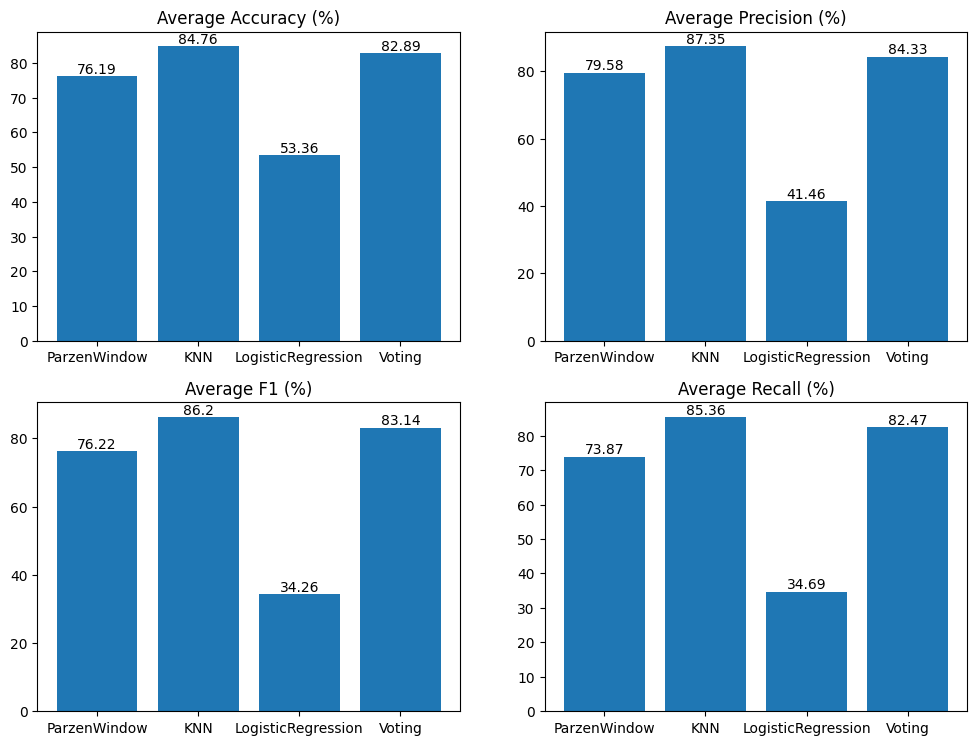

In [118]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=100)

for ax, metric in zip(axs.flatten(), scoring.keys()):
  values = list(map(np.mean, 
                    [pw_metrics_results[metric], knn_metrics_results[metric],
                    lr_metrics_results[metric], vc_metrics_results[metric]]))

  bars = ax.bar(['ParzenWindow', 'KNN', 'LogisticRegression', 'Voting'],
                list(map(lambda x: float(f'{(x*100):.02f}'), values)))
  ax.set_title(f'Average {metric} (%)')
  ax.bar_label(bars)

plt.plot()

#Intervalos de Confiança

In [119]:
for metric in scoring.keys():
  values = list(map(lambda x: DescrStatsW(x).tconfint_mean(), 
                    [pw_metrics_results[metric], knn_metrics_results[metric],
                    lr_metrics_results[metric], vc_metrics_results[metric]]))
  
  for alg, (lwb, upb) in zip(['ParzenWindow', 'KNN', 'LogisticRegression', 'Voting'], values):
    print(f'{metric} {alg} - Lower Bound: {100*lwb:.02f}% Upper Bound: {100*upb:.02f}%')
  print()

Accuracy ParzenWindow - Lower Bound: 76.09% Upper Bound: 76.28%
Accuracy KNN - Lower Bound: 84.68% Upper Bound: 84.84%
Accuracy LogisticRegression - Lower Bound: 53.31% Upper Bound: 53.42%
Accuracy Voting - Lower Bound: 82.80% Upper Bound: 82.98%

Precision ParzenWindow - Lower Bound: 79.41% Upper Bound: 79.75%
Precision KNN - Lower Bound: 87.22% Upper Bound: 87.48%
Precision LogisticRegression - Lower Bound: 41.29% Upper Bound: 41.64%
Precision Voting - Lower Bound: 84.15% Upper Bound: 84.50%

F1 ParzenWindow - Lower Bound: 76.06% Upper Bound: 76.37%
F1 KNN - Lower Bound: 86.09% Upper Bound: 86.32%
F1 LogisticRegression - Lower Bound: 34.16% Upper Bound: 34.37%
F1 Voting - Lower Bound: 83.00% Upper Bound: 83.28%

Recall ParzenWindow - Lower Bound: 73.68% Upper Bound: 74.05%
Recall KNN - Lower Bound: 85.22% Upper Bound: 85.50%
Recall LogisticRegression - Lower Bound: 34.61% Upper Bound: 34.77%
Recall Voting - Lower Bound: 82.32% Upper Bound: 82.62%



Average Accuracy: 0.7618616554136053
Average Precision: 0.7957844277256062
Average F1: 0.7621563077221727
Average Recall: 0.7386680323289264


Text(0.5, 0.98, 'Parzen Window Classifier')

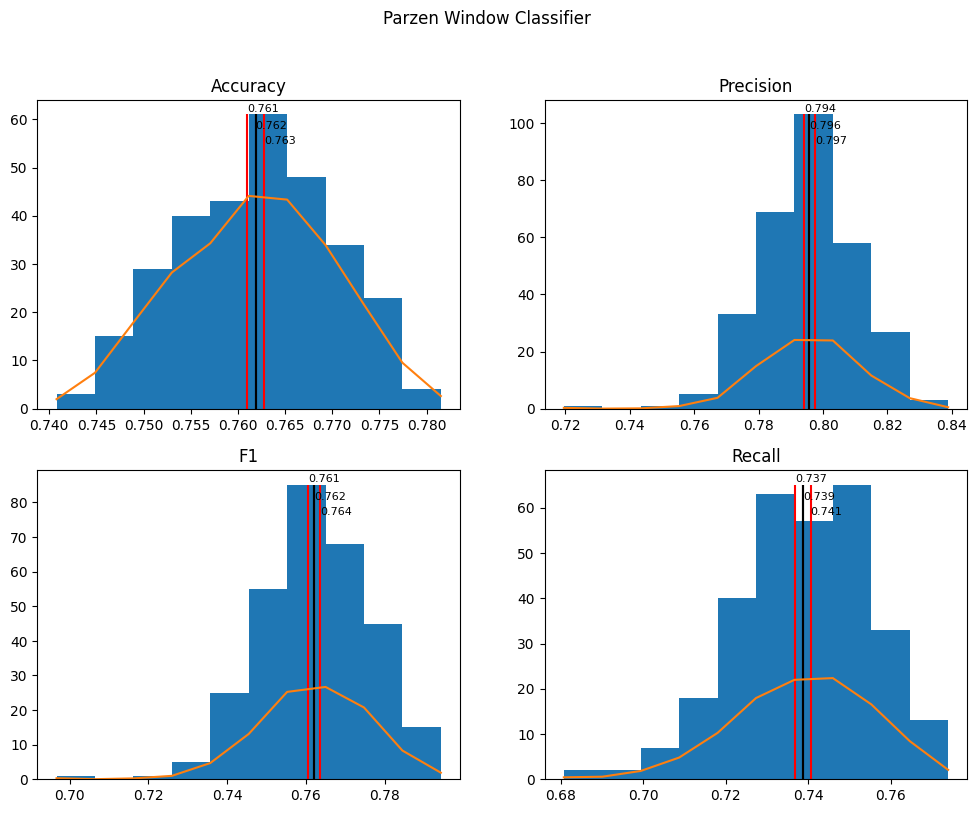

In [158]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=100)

for ax, (k, v) in zip(axs.flatten(), pw_metrics_results.items()):
  t = ax.hist(v)
  lower_bound, upper_bound = DescrStatsW(v).tconfint_mean()
  ax.text(lower_bound, max(t[0])*1.01, f'{lower_bound:.03f}', fontsize = 8)
  ax.text(upper_bound, max(t[0])*0.9, f'{upper_bound:.03f}', fontsize = 8)
  ax.vlines(x=(lower_bound, upper_bound), colors='r', ymin=0, ymax=max(t[0]))
  ax.text(np.mean(v), max(t[0])*0.95, f'{np.mean(v):.03f}', fontsize = 8)
  ax.vlines(x=(np.mean(v), np.mean(v)), colors='black', ymin=0, ymax=max(t[0]))
  density = stats.gaussian_kde(v)
  ax.plot(t[1], density(t[1]))
  print(f'Average {k}: {np.mean(v)}')
  ax.set_title(k)

fig.suptitle("Parzen Window Classifier")

Average Accuracy: 0.8476078282472129
Average Precision: 0.8735163595531726
Average F1: 0.8620451650765638
Average Recall: 0.8536360097199239


Text(0.5, 0.98, 'KNN Classifier')

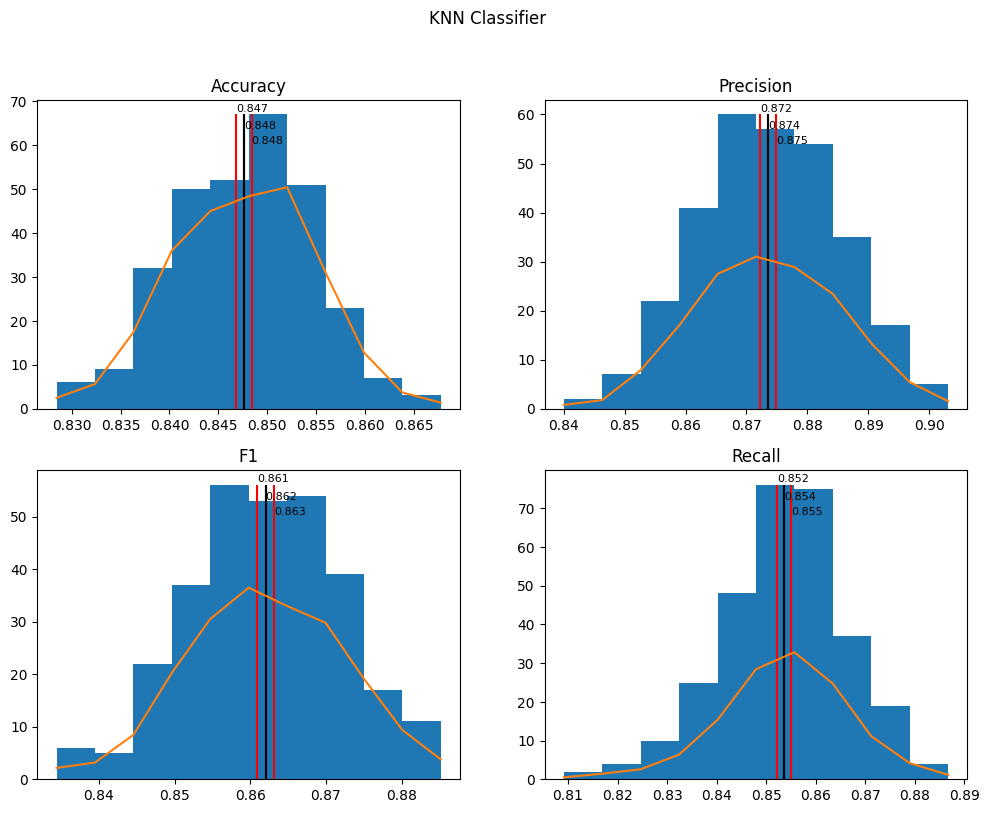

In [159]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=100)

for ax, (k, v) in zip(axs.flatten(), knn_metrics_results.items()):
  t = ax.hist(v)
  lower_bound, upper_bound = DescrStatsW(v).tconfint_mean()
  ax.text(lower_bound, max(t[0])*1.01, f'{lower_bound:.03f}', fontsize = 8)
  ax.text(upper_bound, max(t[0])*0.9, f'{upper_bound:.03f}', fontsize = 8)
  ax.vlines(x=(lower_bound, upper_bound), colors='r', ymin=0, ymax=max(t[0]))
  ax.text(np.mean(v), max(t[0])*0.95, f'{np.mean(v):.03f}', fontsize = 8)
  ax.vlines(x=(np.mean(v), np.mean(v)), colors='black', ymin=0, ymax=max(t[0]))
  density = stats.gaussian_kde(v)
  ax.plot(t[1], density(t[1]))
  print(f'Average {k}: {np.mean(v)}')
  ax.set_title(k)

fig.suptitle("KNN Classifier")

Average Accuracy: 0.30105771426182537
Average Precision: 0.38042581229124833
Average F1: 0.36536072411900977
Average Recall: 0.4724060749237866


Text(0.5, 0.98, 'Bayesiano Gaussiano')

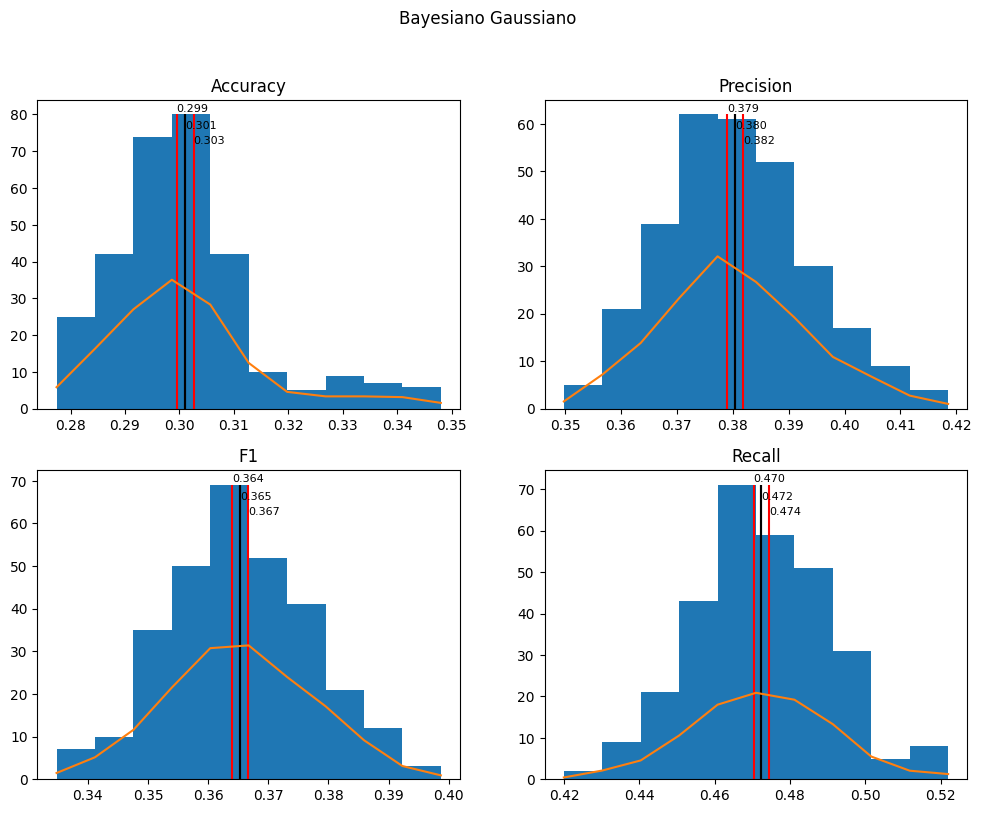

In [160]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=100)

for ax, (k, v) in zip(axs.flatten(), nb_metrics_results.items()):
  t = ax.hist(v)
  lower_bound, upper_bound = DescrStatsW(v).tconfint_mean()
  ax.text(lower_bound, max(t[0])*1.01, f'{lower_bound:.03f}', fontsize = 8)
  ax.text(upper_bound, max(t[0])*0.9, f'{upper_bound:.03f}', fontsize = 8)
  ax.vlines(x=(lower_bound, upper_bound), colors='r', ymin=0, ymax=max(t[0]))  
  ax.text(np.mean(v), max(t[0])*0.95, f'{np.mean(v):.03f}', fontsize = 8)
  ax.vlines(x=(np.mean(v), np.mean(v)), colors='black', ymin=0, ymax=max(t[0]))
  density = stats.gaussian_kde(v)
  ax.plot(t[1], density(t[1]))
  print(f'Average {k}: {np.mean(v)}')
  ax.set_title(k)

fig.suptitle("Bayesiano Gaussiano")

Average Accuracy: 0.533624073787373
Average Precision: 0.4146352625600509
Average F1: 0.3426396447667264
Average Recall: 0.3469073053993612


Text(0.5, 0.98, 'Logistic Regressor Classifier')

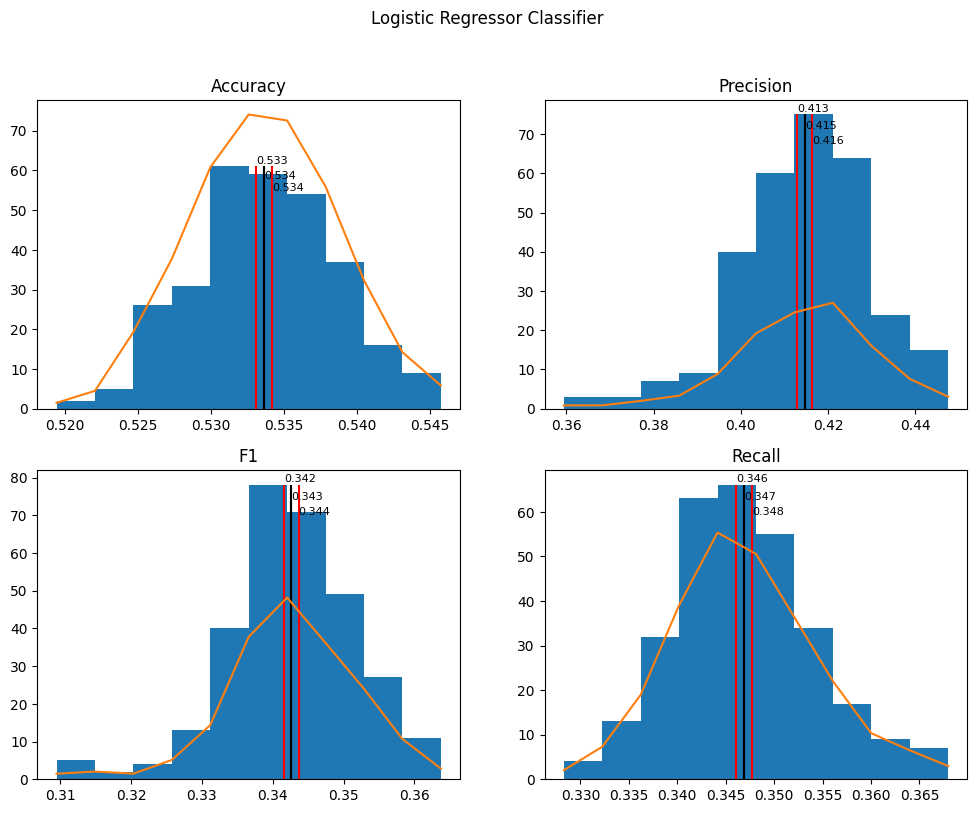

In [161]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=100)

for ax, (k, v) in zip(axs.flatten(), lr_metrics_results.items()):
  t = ax.hist(v)
  lower_bound, upper_bound = DescrStatsW(v).tconfint_mean()
  ax.text(lower_bound, max(t[0])*1.01, f'{lower_bound:.03f}', fontsize = 8)
  ax.text(upper_bound, max(t[0])*0.9, f'{upper_bound:.03f}', fontsize = 8)
  ax.vlines(x=(lower_bound, upper_bound), colors='r', ymin=0, ymax=max(t[0]))
  ax.text(np.mean(v), max(t[0])*0.95, f'{np.mean(v):.03f}', fontsize = 8)
  ax.vlines(x=(np.mean(v), np.mean(v)), colors='black', ymin=0, ymax=max(t[0]))
  density = stats.gaussian_kde(v)
  ax.plot(t[1], density(t[1]))
  print(f'Average {k}: {np.mean(v)}')  
  ax.set_title(k)

fig.suptitle("Logistic Regressor Classifier")

Average Accuracy: 0.828892460487184
Average Precision: 0.8432678959150297
Average F1: 0.8313707076430139
Average Recall: 0.8246917875424776


Text(0.5, 0.98, 'Voto Majoritário')

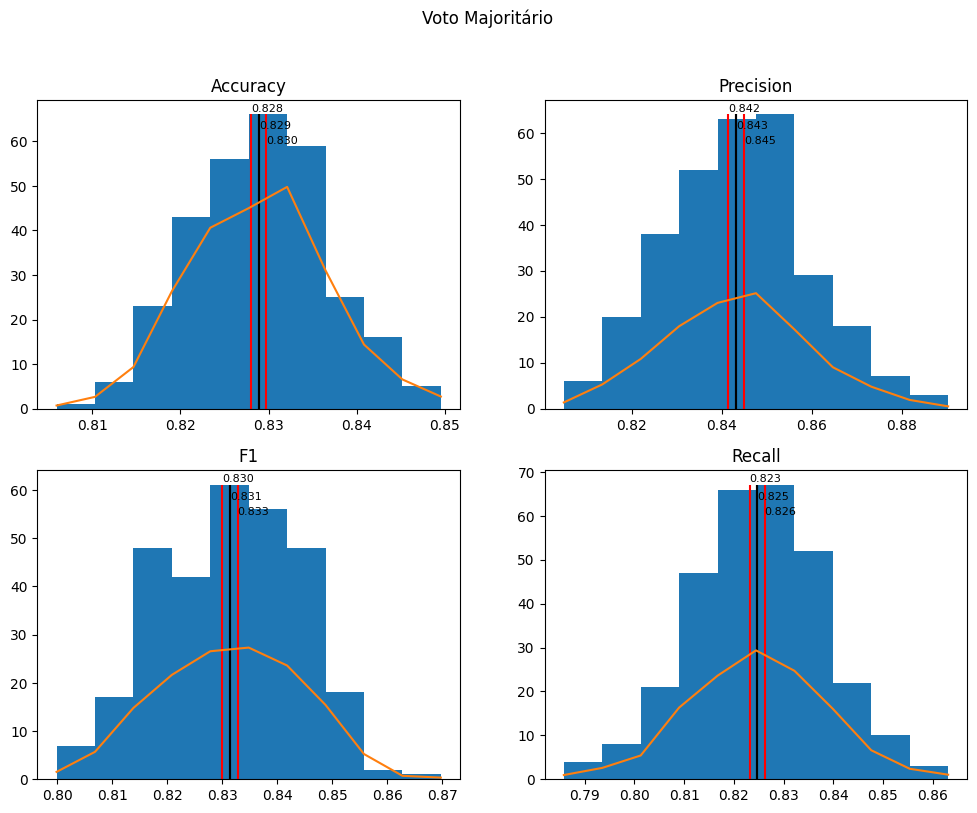

In [162]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=100)

for ax, (k, v) in zip(axs.flatten(), vc_metrics_results.items()):
  t = ax.hist(v)
  lower_bound, upper_bound = DescrStatsW(v).tconfint_mean()
  ax.text(lower_bound, max(t[0])*1.01, f'{lower_bound:.03f}', fontsize = 8)
  ax.text(upper_bound, max(t[0])*0.9, f'{upper_bound:.03f}', fontsize = 8)
  ax.vlines(x=(lower_bound, upper_bound), colors='r', ymin=0, ymax=max(t[0]))  
  ax.text(np.mean(v), max(t[0])*0.95, f'{np.mean(v):.03f}', fontsize = 8)
  ax.vlines(x=(np.mean(v), np.mean(v)), colors='black', ymin=0, ymax=max(t[0]))
  density = stats.gaussian_kde(v)
  ax.plot(t[1], density(t[1]))
  print(f'Average {k}: {np.mean(v)}')
  ax.set_title(k)

fig.suptitle("Voto Majoritário")

#Friedman Test

In [147]:
for metric in scoring:
  print(f'{metric}: {stats.friedmanchisquare(pw_metrics_results[metric], knn_metrics_results[metric], lr_metrics_results[metric], vc_metrics_results[metric], nb_metrics_results[metric])}')

Accuracy: FriedmanchisquareResult(statistic=1200.0, pvalue=1.5928883283555285e-258)
Precision: FriedmanchisquareResult(statistic=1184.9653333333335, pvalue=2.893711849937877e-255)
F1: FriedmanchisquareResult(statistic=1191.5226666666667, pvalue=1.096329442895119e-256)
Recall: FriedmanchisquareResult(statistic=1200.0, pvalue=1.5928883283555285e-258)


#Nemenyi Test

In [153]:
for metric in scoring:
  data = np.array([pw_metrics_results[metric], knn_metrics_results[metric], lr_metrics_results[metric], vc_metrics_results[metric], nb_metrics_results[metric]])
  print(metric)
  print(sp.posthoc_nemenyi_friedman(data.T).head())
  #print(sp.posthoc_nemenyi_friedman(data.T).to_latex())
  print()

Accuracy
       0      1      2      3      4
0  1.000  0.001  0.001  0.001  0.001
1  0.001  1.000  0.001  0.001  0.001
2  0.001  0.001  1.000  0.001  0.001
3  0.001  0.001  0.001  1.000  0.001
4  0.001  0.001  0.001  0.001  1.000

Precision
       0      1      2      3      4
0  1.000  0.001  0.001  0.001  0.001
1  0.001  1.000  0.001  0.001  0.001
2  0.001  0.001  1.000  0.001  0.001
3  0.001  0.001  0.001  1.000  0.001
4  0.001  0.001  0.001  0.001  1.000

F1
       0      1      2      3      4
0  1.000  0.001  0.001  0.001  0.001
1  0.001  1.000  0.001  0.001  0.001
2  0.001  0.001  1.000  0.001  0.001
3  0.001  0.001  0.001  1.000  0.001
4  0.001  0.001  0.001  0.001  1.000

Recall
       0      1      2      3      4
0  1.000  0.001  0.001  0.001  0.001
1  0.001  1.000  0.001  0.001  0.001
2  0.001  0.001  1.000  0.001  0.001
3  0.001  0.001  0.001  1.000  0.001
4  0.001  0.001  0.001  0.001  1.000

